Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [103]:
from random import random, seed
from itertools import accumulate
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
from collections import deque

from icecream import ic

np.set_printoptions(linewidth=200)

# Credits  

The following program was written individually. Some functions are taken from the solution the professor showcased in class during the 3 hours dedicated to this first lab.

# Summary  
The results are:

| Instance | Universe size | Number of sets | Density | Cost       |
|----------|---------------|----------------|---------|------------|
| 1        | 100           | 10             | 0.2     | 257.18     |
| 2        | 1000          | 100            | 0.2     | 7_033.05    |
| 3        | 10000         | 1000           | 0.2     | 127_366.94  |
| 4        | 100000        | 10000          | 0.1     | 81_199_577.48 ** |
| 5        | 100000        | 10000          | 0.2     | 175_851_469.62 ** |
| 6        | 100000        | 10000          | 0.3     | -- *** |

** These results are so bad because not enough steps were taken. I should have favored a solution that started with a much wider step, but I realized that too late, as I didn't realize I had to run all the instances.  
*** As stated above, the run on the harder instances were started too late, and at 240 minutes didn't complete yet. I could have dedicated more time to the optimization of the code, or could have finished earliner, but I wouldn't have toyed with the different approaches and parameters as much on the other file, which I find to be much more useful from a learning perspective.

Comparing my results with those of some of my colleagues, which used many different techinques, the results don't seem to differ much, meaning that the more complicated approaches don't guarantee that much increase in fitness.  
As stated in the comment of the table, there is instead for sure a difference in performance between different approaches. An algorithm taking much wider steps when realizing that there is a lot of fitness increase would have reached the optimization peak are much earlier, allowing me to find an actual optimum in those 10_000 steps.


# Helper Functions

In [104]:
def valid(solution: np.ndarray) -> bool:
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution: np.ndarray) -> float:
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution: np.ndarray) -> float:
    """Returns the fitness of a solution as just the negative of cost"""
    return (valid(solution), -cost(solution))

def tweak__single(solution: np.ndarray, my_rng) -> np.ndarray:
    new_sol = solution.copy()
    i = my_rng.integers(NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol

def tweak__single_or_double(solution: np.ndarray, mutation_prob: float, my_rng) -> np.ndarray:
    new_sol = solution.copy()
    i = my_rng.integers(NUM_SETS)
    new_sol[i] = not new_sol[i]
    
    if my_rng.random() < mutation_prob:
        j = my_rng.integers(NUM_SETS)
        new_sol[j] = not new_sol[j]
    
    return new_sol
    
def tweak__multiple(solution: np.ndarray, strength: float, my_rng) -> np.ndarray:
    mask = my_rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True

    new_sol = np.logical_xor(solution, mask)
    return new_sol

# Hill Climbers

#### Simulated Annealing

In [105]:
def simulated_annealing(my_starting_solution: np.ndarray, my_rng, instance) -> float:
    """ Simulated Annealing algorithm for the Set Covering Problem
        It uses a single-bit-flip tweak, constant temperature set at """
    # 1) Computing the solution using constant temperature
    solution = my_starting_solution
    best_solution_ever = solution  # This is needed because we allow for worse solutions to be accepted
    cur_fitness = fitness(solution)
    initial_fitness = cur_fitness
    history = [cur_fitness]
    ps = []
    difs = []

    temperature = np.exp(np.log(UNIVERSE_SIZE) / 16)

    for steps in range(10_000):
        new_solution = tweak__single_or_double(solution, 0.3, my_rng)
        new_fitness = fitness(new_solution)
        history.append(new_fitness)

        if new_fitness > cur_fitness:
            solution = new_solution
            cur_fitness = new_fitness
        elif new_fitness == cur_fitness:
            continue
        else:
            p = np.exp(-(np.abs(cur_fitness[1] - new_fitness[1])) / temperature)
            ps.append(p)
            difs.append(np.abs(cur_fitness[1] - new_fitness[1]))

            if my_rng.random() < p:
                solution = new_solution
                cur_fitness = new_fitness

        if cur_fitness > fitness(best_solution_ever):
            best_solution_ever = solution

    best_fitness_ever = fitness(best_solution_ever)

    # 2) Plotting the solution exploration
    plt.figure(figsize=(14, 8))
    plt.title(f"Simulated Annealing HC - constant temperature\nInstance: UNIVERSE_SIZE={instance['UNIVERSE_SIZE']}, NUM_SETS={instance['NUM_SETS']}, DENSITY={instance['DENSITY']}")

    plt.plot(range(len(history)), list(accumulate([f[1] for f in history], max)), color="red") # Plot only valid tweaks' fitness
    _ = plt.scatter(range(len(history)), [f[1] for f in history], marker=".")  # Plot all tweak's fitness
    plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    plt.text(0.95, 0.10, f'Best Ever Fitness: {best_fitness_ever}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    plt.show()

    return best_fitness_ever[1]

#### Tabu

In [122]:
def tabu(my_starting_solution: np.ndarray, my_rng, instance: dict, strength: float) -> float:
    """ Computing the solution with more chance for double mutation """
    solution = my_starting_solution
    cur_fitness = fitness(solution)
    initial_fitness = cur_fitness
    history = [cur_fitness[1]]

    tabu = []

    for _ in range(10_000):
        for _ in range(100):
            new_solution = tweak__single_or_double(solution, strength, my_rng)
            new_fitness = fitness(new_solution)

            if tuple(new_solution) in tabu:
                continue
            break

        tabu.append(tuple(new_solution))
        history.append(new_fitness[1])

        if new_fitness > cur_fitness:
            solution = new_solution
            cur_fitness = new_fitness
            ic(cur_fitness)

    """ Plotting the solution exploration """
    plt.figure(figsize=(14, 8))

    if strength < 0.001:
        plt.title(f"Single Tweak HC - UNIVERSE_SIZE={instance['UNIVERSE_SIZE']}, NUM_SETS={instance['NUM_SETS']}, DENSITY={instance['DENSITY']}")
    else:
        plt.title(f"Single/Double Tweak HC - {strength*100}% chance of double mutation: UNIVERSE_SIZE={instance['UNIVERSE_SIZE']}, NUM_SETS={instance['NUM_SETS']}, DENSITY={instance['DENSITY']}")
    
    plt.plot(range(len(history)), list(accumulate(history, max)), color="red")  # Growth-only Tweaks
    _ = plt.scatter(range(len(history)), history, marker=".")  # All Tweaks

    plt.text(0.95, 0.05, f'Initial Fitness: {initial_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
    plt.text(0.95, 0.10, f'Current Fitness: {cur_fitness}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')

    return cur_fitness[1]

# Helper Functions

In [112]:
def valid(solution: np.ndarray) -> bool:
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution: np.ndarray) -> float:
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution: np.ndarray) -> float:
    """Returns the fitness of a solution as just the negative of cost"""
    return (valid(solution), -cost(solution))

def tweak__single(solution: np.ndarray, my_rng) -> np.ndarray:
    new_sol = solution.copy()
    i = my_rng.integers(NUM_SETS)
    new_sol[i] = not new_sol[i]
    return new_sol

def tweak__single_or_double(solution: np.ndarray, mutation_prob: float, my_rng) -> np.ndarray:
    new_sol = solution.copy()
    i = my_rng.integers(NUM_SETS)
    new_sol[i] = not new_sol[i]
    
    if my_rng.random() < mutation_prob:
        j = my_rng.integers(NUM_SETS)
        new_sol[j] = not new_sol[j]
    
    return new_sol
    
def tweak__multiple(solution: np.ndarray, strength: float, my_rng) -> np.ndarray:
    mask = my_rng.random(NUM_SETS) < strength
    if not np.any(mask):
        mask[np.random.randint(NUM_SETS)] = True

    new_sol = np.logical_xor(solution, mask)
    return new_sol

# Running All The Different Instances

ic| instance: {'DENSITY': 0.2, 'NUM_SETS': 10, 'UNIVERSE_SIZE': 100}
    valid(starting_solution): np.True_


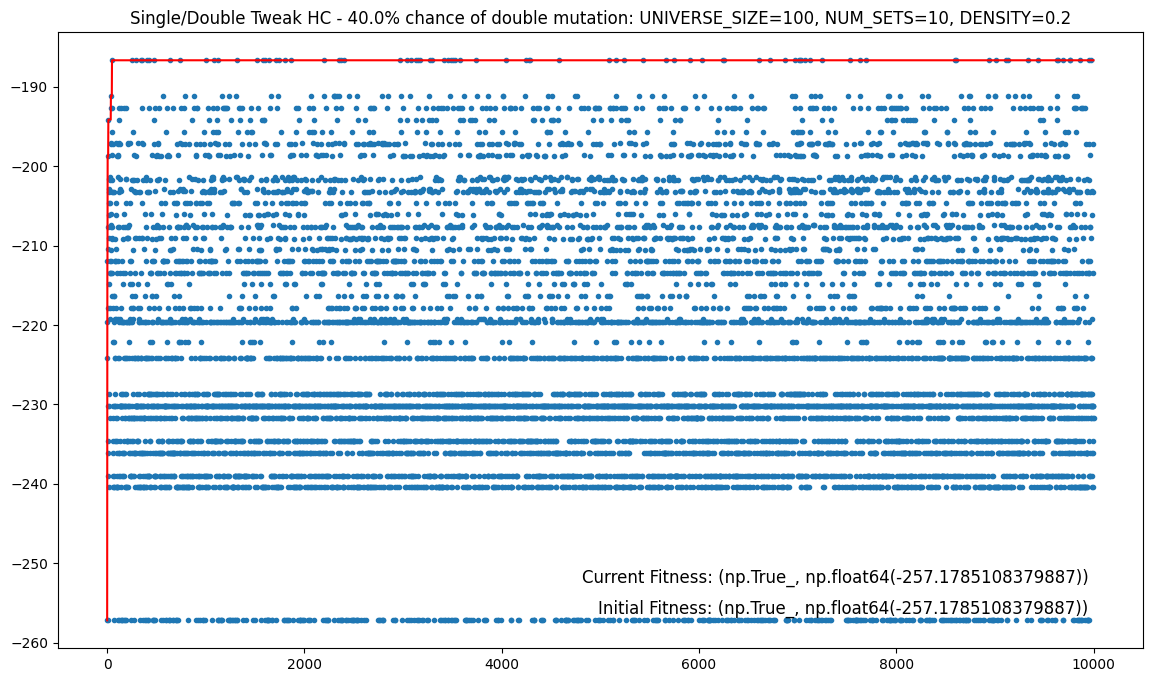

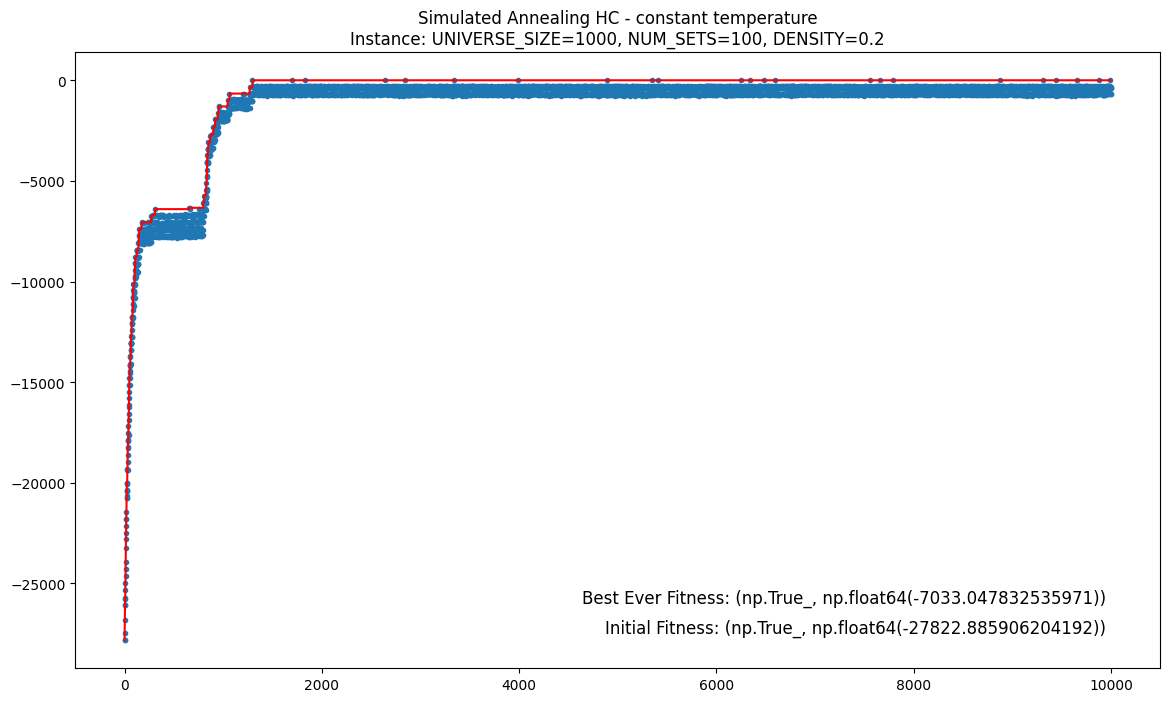

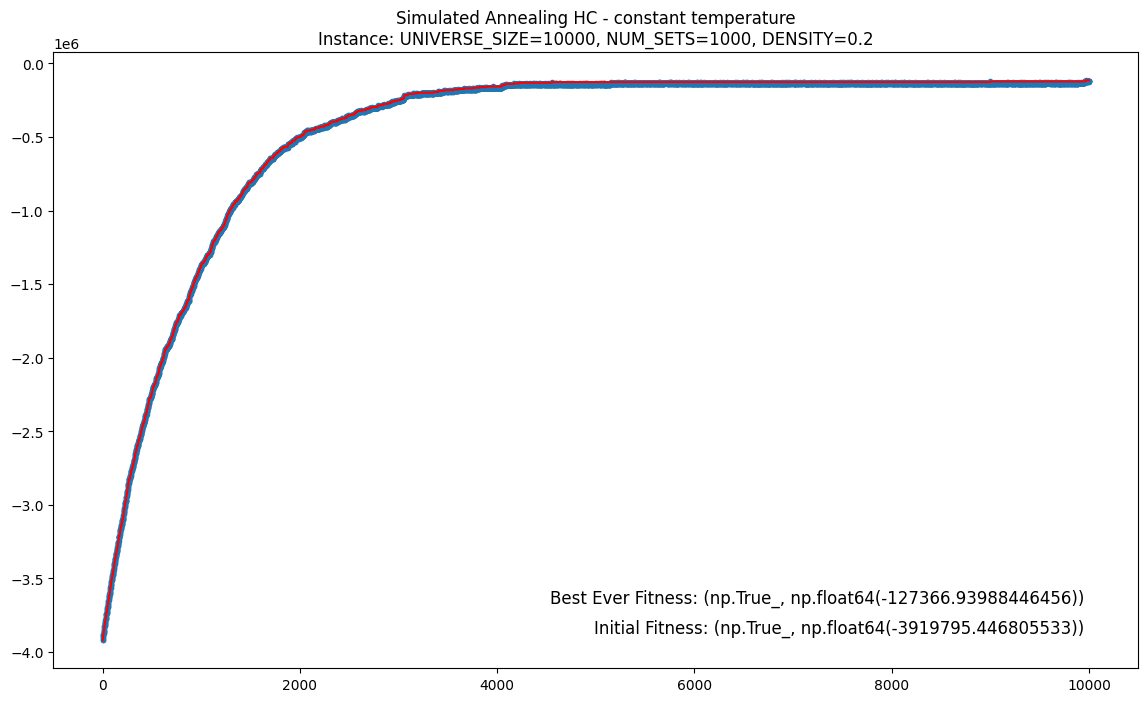

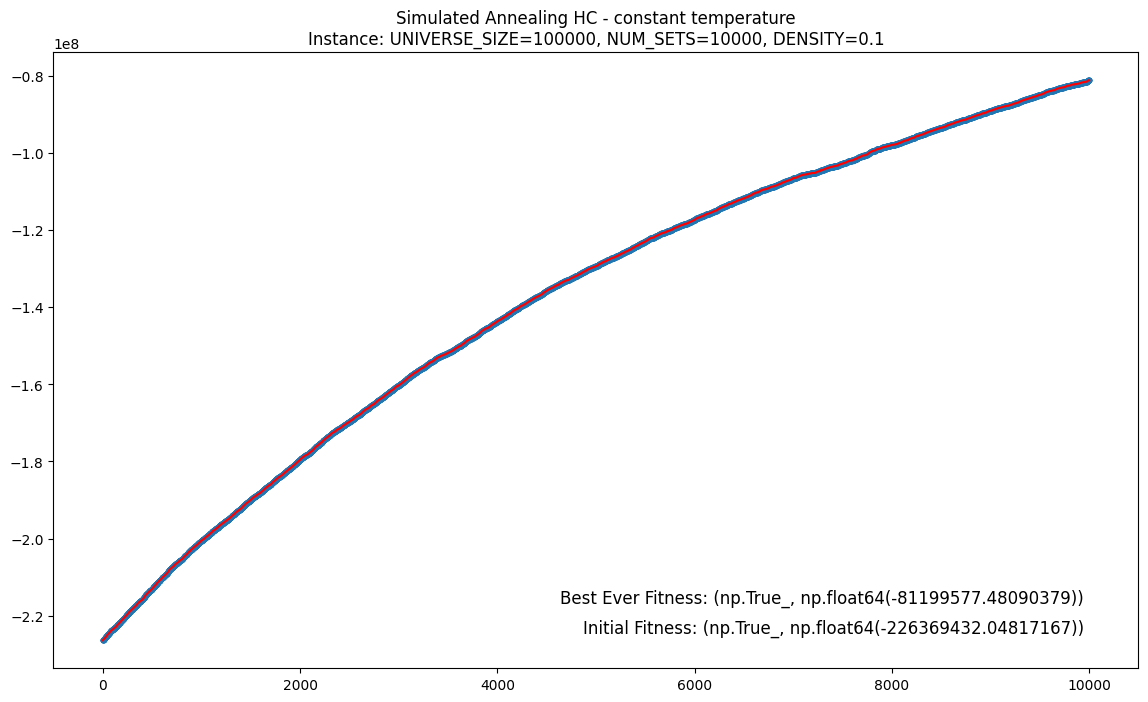

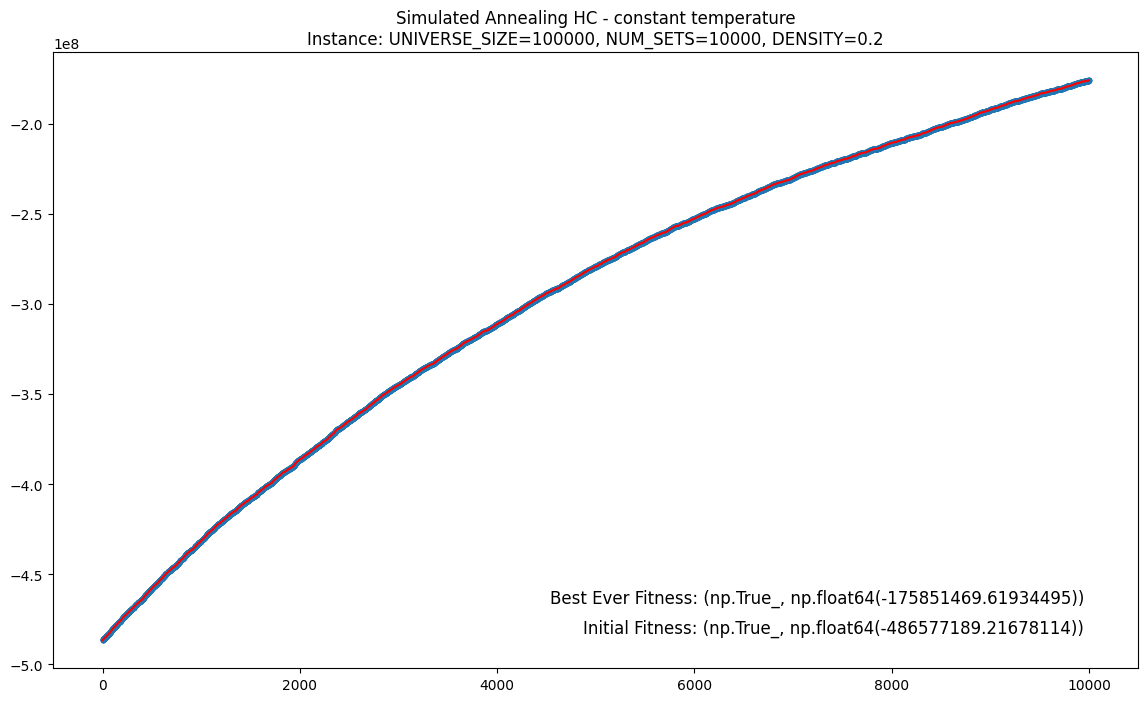

KeyboardInterrupt: 

In [126]:
# Instance 1
instances = [   {'UNIVERSE_SIZE': 100, 'NUM_SETS': 10, 'DENSITY': 0.2},
                {'UNIVERSE_SIZE': 1_000, 'NUM_SETS': 100, 'DENSITY': 0.2},
                {'UNIVERSE_SIZE': 10_000, 'NUM_SETS': 1_000, 'DENSITY': 0.2},
                {'UNIVERSE_SIZE': 100_000, 'NUM_SETS': 10_000, 'DENSITY': 0.1},
                {'UNIVERSE_SIZE': 100_000, 'NUM_SETS': 10_000, 'DENSITY': 0.2},
                {'UNIVERSE_SIZE': 100_000, 'NUM_SETS': 10_000, 'DENSITY': 0.3}]

fitnesses = []

for (i, instance) in enumerate(instances):
    UNIVERSE_SIZE = instance['UNIVERSE_SIZE']
    NUM_SETS = instance['NUM_SETS']
    DENSITY = instance['DENSITY']

    rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))
    starting_solution = rng.random(NUM_SETS) < 0.9

    # DON'T EDIT THESE LINES!

    SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
    for s in range(UNIVERSE_SIZE):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(NUM_SETS), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)

    if i == 0:
        starting_solution = rng.random(NUM_SETS) < 1.1
        ic(instance, valid(starting_solution))
        fitnesses.append(tabu(starting_solution, rng, instance, 0.4))
    else:
        fitnesses.append(simulated_annealing(starting_solution, rng, instance))